In [152]:
import sys
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import re
from collections import deque
import sklearn
# test classification dataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
import xgboost as xgb
from xgboost.callback import EarlyStopping
import warnings
import seaborn as sns
from sklearn.metrics import mean_squared_error
# test classification dataset
from sklearn.datasets import make_classification
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

In [153]:
# Step 1: Read the dataframe from a CSV (you can replace this with other data input methods)
df = pd.read_csv('~/data/phasing/NA12878/6finalized/predict_phasing_error_data.tsv',sep='\t')
df.head()

,error,chr,distance,log10_distance,d,r2,AF,EUR_MAF,lag_EUR_MAF,min_EUR_MAF,diff_EUR_MAF
0,0,chr1,88,1.944483,1.0,0.914,0.509585,0.490415,0.4006,0.4006,0.0099
1,0,chr1,1609,3.206556,1.0,0.503,0.758586,0.241414,0.4105,0.2416,0.1689
2,0,chr1,1010,3.004321,1.0,1.000,0.799920,0.200080,0.0875,0.0825,0.0050
3,0,chr1,53,1.724276,1.0,1.000,0.835863,0.164137,0.0825,0.0795,0.0030
4,0,chr1,4676,3.669875,1.0,0.837,0.929313,0.070687,0.0795,0.0666,0.0129


### Data exploration

### Extreme Gradient Boosting

In [55]:
warnings.filterwarnings("ignore")
diamonds = sns.load_dataset("diamonds")
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [27]:
diamonds.shape

(53940, 10)

In [28]:
diamonds.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [29]:
diamonds.describe(exclude=np.number)

,cut,color,clarity
count,53940,53940,53940
unique,5,7,8
top,Ideal,G,SI1
freq,21551,11292,13065


##### predict diamond prices using their physical measurements

In [58]:
# Extract feature and target arrays
X, y = diamonds.drop('price', axis=1), diamonds[['price']]

In [59]:
X

,carat,cut,color,clarity,depth,table,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,6.15,6.12,3.74


##### Normally, you would encode them with ordinal or one-hot encoding, but XGBoost has the ability to internally deal with categoricals.

In [60]:
# Extract text features
cats = X.select_dtypes(exclude=np.number).columns.tolist()

# Convert to Pandas category
for col in cats:
   X[col] = X[col].astype('category')

In [61]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [33]:
# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)


In [62]:
# mse = np.mean((actual - predicted) ** 2)
# rmse = np.sqrt(mse)


NameError: name 'actual' is not defined

##### Training

In [64]:
# Define hyperparameters
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}

n = 100
model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
)

##### Evaluation

In [65]:
preds = model.predict(dtest_reg)

In [66]:
rmse = mean_squared_error(y_test, preds, squared=False)

print(f"RMSE of the base model: {rmse:.3f}")

RMSE of the base model: 555.607


##### Using Validation Sets During Training, early stopping (5000 boosting rounds with the verbosity of 500)

In [71]:
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}
# the more rounds there are, the more XGBoost tries to minimize the loss
n = 10000

evals = [(dtest_reg, "validation"), (dtrain_reg, "train")]
# Early stopping forces XGBoost to watch the validation loss, and if it stops improving for a specified number of rounds, it automatically stops training.

model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
   verbose_eval=500,
   # Activate early stopping
   early_stopping_rounds=50
)

[0]	validation-rmse:2817.38773	train-rmse:2874.29379
[500]	validation-rmse:563.29248	train-rmse:197.72375
[1000]	validation-rmse:572.18689	train-rmse:121.69016
[1500]	validation-rmse:576.42698	train-rmse:84.17960
[2000]	validation-rmse:578.58142	train-rmse:60.88001
[2500]	validation-rmse:579.96944	train-rmse:46.47975
[3000]	validation-rmse:580.78514	train-rmse:36.59124
[3500]	validation-rmse:581.36774	train-rmse:29.47363
[4000]	validation-rmse:581.86083	train-rmse:23.90580
[4500]	validation-rmse:582.07031	train-rmse:19.97500
[5000]	validation-rmse:582.23123	train-rmse:17.15711
[5500]	validation-rmse:582.40910	train-rmse:15.00659
[6000]	validation-rmse:582.49056	train-rmse:13.42440
[6500]	validation-rmse:582.54236	train-rmse:12.33491
[7000]	validation-rmse:582.57662	train-rmse:11.51327
[7500]	validation-rmse:582.65106	train-rmse:10.90900
[8000]	validation-rmse:582.67820	train-rmse:10.47660
[8500]	validation-rmse:582.72539	train-rmse:10.16553
[9000]	validation-rmse:582.75673	train-rmse:9

##### Cross validation

In [72]:
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}
n = 1000

results = xgb.cv(
   params, dtrain_reg,
   num_boost_round=n,
   nfold=5,
   early_stopping_rounds=20
)

In [73]:
results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,2874.530912,9.576510,2877.437274,37.093540
1,2089.327469,8.317290,2094.021636,24.828795
2,1550.617973,5.223297,1558.386252,18.540267
3,1183.812759,5.193420,1195.032441,13.471580
4,941.203113,4.539805,958.728828,9.479449


In [74]:
best_rmse = results['test-rmse-mean'].min()

best_rmse

549.311480649509

#### Read in GIAB data

In [140]:
# Step 1: Read the dataframe from a CSV (you can replace this with other data input methods)
original_df = pd.read_csv('~/data/phasing/NA12878/6finalized/exonPhasedSites_final_matrix_17459_finalized_modelinput.tsv',sep='\t')
original_df.head()

,chr,pos,lag_pos,rsid,exon_start,exon_end,geneID,error,distance,log10_distance,r2,d,EUR_MAF,lag_EUR_MAF,min_EUR_MAF,diff_EUR_MAF
0,chr1,914940,914852,rs13303033,914260,916037,ENSG00000187642,0,88,1.944483,0.914,1.0,0.490415,0.4006,0.4006,0.0099
1,chr1,916549,914940,rs6660139,916516,916553,ENSG00000187642,0,1609,3.206556,0.503,1.0,0.241414,0.4105,0.2416,0.1689
2,chr1,982941,981931,rs3128102,982854,983067,ENSG00000188157,0,1010,3.004321,1.000,1.0,0.200080,0.0875,0.0825,0.0050
3,chr1,982994,982941,rs10267,982854,983067,ENSG00000188157,0,53,1.724276,1.000,1.0,0.164137,0.0825,0.0795,0.0030
4,chr1,987670,982994,rs13303287,987365,989357,ENSG00000188157,0,4676,3.669875,0.837,1.0,0.070687,0.0795,0.0666,0.0129


In [141]:
# Step 2: Group by 'geneID' and remove the first SNP pair per gene by setting 'error' to NaN for the first row in each group
original_df['error'] = original_df.groupby('geneID')['error'].apply(lambda x: x.where(x.index != x.index[0], other=pd.NA))

# Filter out rows with NaN values in the 'error' column and select the required columns
filtered_df = original_df[['error', 'log10_distance', 'min_EUR_MAF', 'diff_EUR_MAF', 'd', 'r2']].dropna(subset=['error'])

TypeError: incompatible index of inserted column with frame index

In [ ]:
# Step 3: Separate features (X) and target (y)
# Assume the target variable is in a column named 'target'
X = df.drop(columns=['error'])  # Drop the target column to get the feature matrix
y = df['error']  # Get the target column

In [142]:
# define dataset
X, y = make_classification(n_samples=10000, n_features=50, n_informative=50, n_redundant=0, random_state=1)

# summarize the dataset
print(X.shape, y.shape)

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=1)

# Create classification matrices
dtrain_clf = xgb.DMatrix(X_train, y_train)
dtest_clf = xgb.DMatrix(X_test, y_test)

# Define XGBoost parameters
params = {
    "objective": "binary:logistic", 
    "tree_method": "gpu_hist", 
    "eval_metric": ["logloss", "auc"],
    'eta': 0.2,
    'lambda': 1.0,
    'alpha': 0.0,
}

n = 10000  # Number of boosting rounds

# Perform cross-validation
cv_results = xgb.cv(
   params, dtrain_clf,
   num_boost_round=n,
   nfold=5,
   metrics=["logloss", "auc"],  # Use binary classification metrics
   early_stopping_rounds=1000,   # Add early stopping if needed
   verbose_eval=True
)

print(cv_results)

(10000, 50) (10000,)
[0]	train-logloss:0.62175+0.00219	train-auc:0.86461+0.00548	test-logloss:0.64732+0.00275	test-auc:0.74994+0.01148
[1]	train-logloss:0.56281+0.00282	train-auc:0.92313+0.00265	test-logloss:0.61120+0.00523	test-auc:0.80220+0.01472
[2]	train-logloss:0.51398+0.00412	train-auc:0.94635+0.00217	test-logloss:0.57870+0.00290	test-auc:0.83354+0.00598
[3]	train-logloss:0.47319+0.00351	train-auc:0.96133+0.00122	test-logloss:0.55190+0.00246	test-auc:0.85437+0.00576
[4]	train-logloss:0.43862+0.00315	train-auc:0.96949+0.00132	test-logloss:0.52880+0.00460	test-auc:0.86751+0.00693
[5]	train-logloss:0.40620+0.00382	train-auc:0.97697+0.00130	test-logloss:0.50650+0.00404	test-auc:0.88147+0.00478
[6]	train-logloss:0.37809+0.00479	train-auc:0.98192+0.00143	test-logloss:0.48854+0.00449	test-auc:0.88949+0.00570
[7]	train-logloss:0.35470+0.00519	train-auc:0.98535+0.00107	test-logloss:0.47244+0.00497	test-auc:0.89728+0.00618
[8]	train-logloss:0.33260+0.00389	train-auc:0.98847+0.00091	test-lo

In [143]:
cv_results.head()

,train-logloss-mean,train-logloss-std,train-auc-mean,train-auc-std,test-logloss-mean,test-logloss-std,test-auc-mean,test-auc-std
0,0.621750,0.002194,0.864607,0.005481,0.647315,0.002747,0.749944,0.011476
1,0.562812,0.002823,0.923130,0.002647,0.611198,0.005226,0.802195,0.014718
2,0.513981,0.004124,0.946355,0.002172,0.578703,0.002896,0.833541,0.005975
3,0.473193,0.003508,0.961331,0.001217,0.551905,0.002464,0.854374,0.005761
4,0.438624,0.003152,0.969486,0.001318,0.528802,0.004604,0.867513,0.006927


In [148]:
cv_results['test-logloss-mean'].max()

0.6473153870463371

In [149]:
cv_results['test-auc-mean'].max()

0.9848912746831886

In [150]:
cv_results

,train-logloss-mean,train-logloss-std,train-auc-mean,train-auc-std,test-logloss-mean,test-logloss-std,test-auc-mean,test-auc-std
0,0.621750,0.002194,0.864607,0.005481,0.647315,0.002747,0.749944,0.011476
1,0.562812,0.002823,0.923130,0.002647,0.611198,0.005226,0.802195,0.014718
2,0.513981,0.004124,0.946355,0.002172,0.578703,0.002896,0.833541,0.005975
3,0.473193,0.003508,0.961331,0.001217,0.551905,0.002464,0.854374,0.005761
4,0.438624,0.003152,0.969486,0.001318,0.528802,0.004604,0.867513,0.006927
...,...,...,...,...,...,...,...,...
2356,0.000801,0.000006,1.000000,0.000000,0.158706,0.014041,0.984889,0.002005
2357,0.000801,0.000006,1.000000,0.000000,0.158715,0.014048,0.984890,0.002007
2358,0.000801,0.000006,1.000000,0.000000,0.158717,0.014042,0.984889,0.002008
2359,0.000801,0.000006,1.000000,0.000000,0.158722,0.014041,0.984891,0.002009


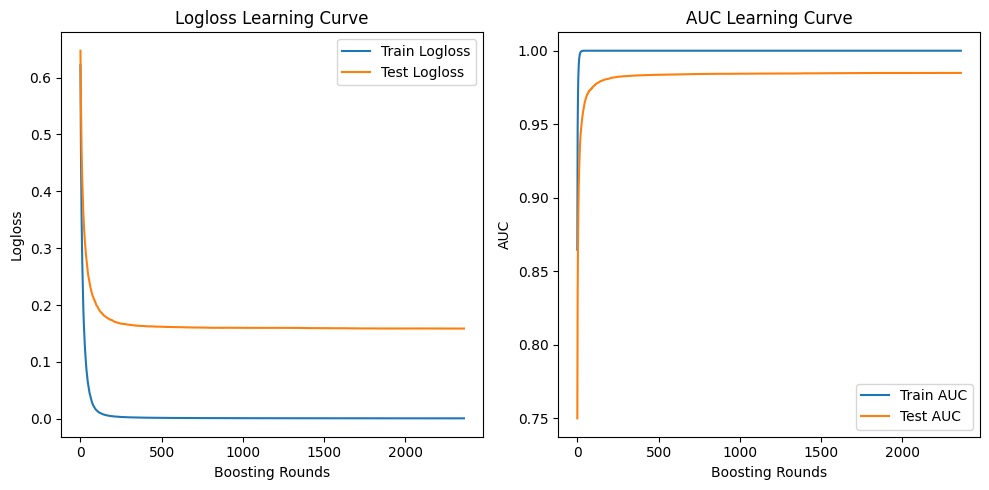

In [151]:
# Extract the columns for logloss and auc
train_logloss = cv_results['train-logloss-mean']
test_logloss = cv_results['test-logloss-mean']
train_auc = cv_results['train-auc-mean']
test_auc = cv_results['test-auc-mean']

# Plot logloss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_logloss, label='Train Logloss')
plt.plot(test_logloss, label='Test Logloss')
plt.xlabel('Boosting Rounds')
plt.ylabel('Logloss')
plt.title('Logloss Learning Curve')
plt.legend()

# Plot auc
plt.subplot(1, 2, 2)
plt.plot(train_auc, label='Train AUC')
plt.plot(test_auc, label='Test AUC')
plt.xlabel('Boosting Rounds')
plt.ylabel('AUC')
plt.title('AUC Learning Curve')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

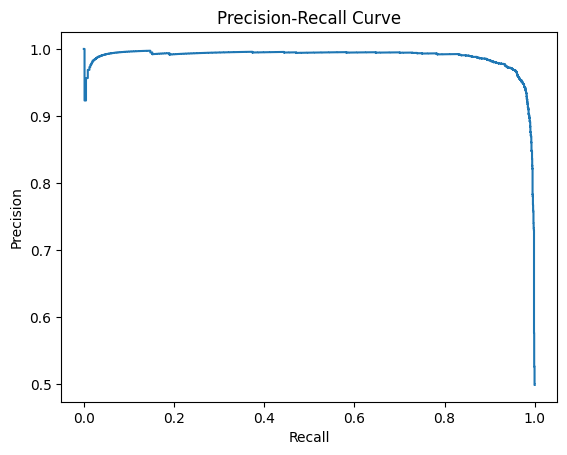

In [135]:
# Step 2: Train a model on the full training data to obtain probabilities
model = xgb.train(params, dtrain_clf, num_boost_round=cv_results.shape[0])

# Obtain predicted probabilities for the test set
y_probs = model.predict(dtest_clf)

# Step 3: Compute Precision-Recall values
precision, recall, _ = precision_recall_curve(y_test, y_probs)

# Step 4: Plot the Precision-Recall curve
plt.figure()
PrecisionRecallDisplay(precision=precision, recall=recall).plot()
plt.title("Precision-Recall Curve")
plt.show()